In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# Lecture 14 (Part A), Interactive multiobjective optimization & DESDEO 

## Interactive methods

* Interactive methods iteratively search for the preferred solution with decision maker and optimization alternating
* Benefits
  * Decision maker gets to learn about
    * the available solutions, and
    * how preferences affect the solutions found
  * Computation is less intensive, because no need to generate a large representation of Pareto optimal solutions
* Drawbacks
  * Needs active involvement from the decision maker
  * If the problem is computationally expensive, then the decision maker may need to wait a long time between solutions


## Interactive methods (cont)
The steps of the general algorithm are the following:
1. Initialize the solution process, e.g., calculate ideal and nadir objective vectors.
2. Generate initial Pareto optimal solution to be used as a current solution.
3. Show the current solution to the decision maker.
4. Ask the decision maker to provide preference information related to the current solution.
5. Generate new solution(s) based on the preference information.
6. Show the solutions generated in step 5 to the decision maker. Ask her/him to select the best solution of those and denote it as the current solution.
7. If the selected current solution is satisfactory for the decision maker, stop. Otherwise, continue from step 4.

![alt text](images/Interactive-Methods.jpg "Interactive methods")

## Interactive methods (cont)

**Interactive methods are one of the main research areas here at the Multiobjective optimization research group**

We will demonstrate interactive methods by using the open source DESDEO framework developed at the research group (https://desdeo.it.jyu.fi/). DESDEO includes implementations of several interactive methods.


### The synchronous NIMBUS Method

Introduced by Professors Kaisa Miettinen and Marko Mäkelä in 2006: 

<a href="https://www.sciencedirect.com/science/article/pii/S0377221704005260?casa_token=wEhNmXe5IQYAAAAA:ZXDms0f3S6J3568D-6ikVG3lHcYLLNaAPT04bBMF45nwUgTqrkpgWIsHhq77HyBfphpaNYad6ek">*Miettinen, K. and Mäkelä, M. M., Synchronous approach in interactive multiobjective optimization, European Journal of Operational Research, 170: 909-922, 2006*</a> 

Is based on classification of objectives into 
* those that should be **improved as much as possible**,
* those that should be **improved until a given limit**,
* those that are **acceptable** at the moment,
* those that can be allowed to **worsen until a given limit**,
* those that are allowed to **move freely** at the moment.

Synchronous NIMBUS is based on representing this information as four different single-objective optimization problems that are then solved and solutions are shown to the decision maker.


![alt text](images/NIMBUS.jpg "NIMBUS method")

![alt text](images/NIMBUS_flow.png "NIMBUS Flowchart")

## A note

**Reference point method:** At each iteration, the decision maker provides a reference point and new solution is generated by using achievement scalarizing problem. Most of the subproblems in the synchronous NIMBUS method are based on this idea.


## Implementations of the NIMBUS method

There also exists a WWW-NIMBUS (https://wwwnimbus.it.jyu.fi/) web implementation (has not been maintained in more than 15 years, but works).

The Synchronous NIMBUS is implemented as a part of IND-NIMBUS (http://ind-nimbus.it.jyu.fi/) software framework (https://mcdm.ue.katowice.pl/files/papers/mcdm05(1)_9.pdf). 

Recently, development of the DESDEO framework (https://desdeo.it.jyu.fi/) has been started to enable open-source framework for interactive multiobjective optimization (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9591595). 


## DESDEO framework

We will have a closer look at the DESDEO framework: https://desdeo.it.jyu.fi/

The following example is from https://desdeo-mcdm.readthedocs.io/en/latest/notebooks/synchronous_nimbus.html. We will have a look at it there. 

The same example can be found below if you want to try it by yourself. 

To install DESDEO you can use:

(!) pip install desdeo 

For more information see the GitHub page at https://github.com/industrial-optimization-group/DESDEO.

In [ ]:
#!pip install desdeo

We will be solving the Kursawe function (see, e.g., https://link.springer.com/article/10.1007/s00500-015-1767-5#:~:text=The%20Kursawe%20test%20function%20(Kursawe,used%20to%20quantify%20the%20results.).

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from desdeo_problem.problem import MOProblem
from desdeo_problem.problem.Variable import variable_builder
from desdeo_problem.problem.Objective import _ScalarObjective

def f_1(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    xs_plusone = np.roll(xs, 1, axis=1)
    return np.sum(-10*np.exp(-0.2*np.sqrt(xs[:, :-1]**2 + xs_plusone[:, :-1]**2)), axis=1)

def f_2(xs: np.ndarray):
    xs = np.atleast_2d(xs)
    return np.sum(np.abs(xs)**0.8 + 5*np.sin(xs**3), axis=1)


varsl = variable_builder(
    ["x_1", "x_2", "x_3"],
    initial_values=[0, 0, 0],
    lower_bounds=[-5, -5, -5],
    upper_bounds=[5, 5, 5],
)

f1 = _ScalarObjective(name="f1", evaluator=f_1)
f2 = _ScalarObjective(name="f2", evaluator=f_2)

problem = MOProblem(variables=varsl, objectives=[f1, f2], ideal=np.array([-20, -12]), nadir=np.array([-14, 0.5]))

To check out the problem, let us compute a representation of the Pareto optimal front of solutions:

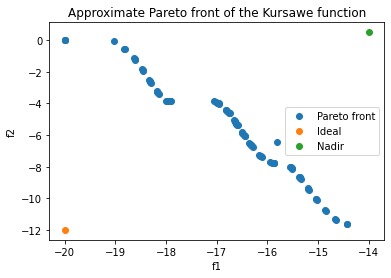

In [3]:
from desdeo_mcdm.utilities.solvers import solve_pareto_front_representation

p_front = solve_pareto_front_representation(problem, step=1.0)[1]

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Now we can get to the NIMBUS part. 

Let us define an instance of the NIMBUS method utilizing our problem defined earlier, and start by invoking the instance’s **start** method:

In [4]:
from desdeo_mcdm.interactive.NIMBUS import NIMBUS

method = NIMBUS(problem, "scipy_de")

classification_request, plot_request = method.start()

Let us look at the keys in the dictionary contained in the classification_request:

In [5]:
print(classification_request.content.keys())

dict_keys(['message', 'objective_values', 'classifications', 'levels', 'number_of_solutions'])


**Message** should give us some more information:

In [6]:
print(classification_request.content["message"])

Please classify each of the objective values in one of the following categories:
	1. values should improve '<'
	2. values should improve until some desired aspiration level is reached '<='
	3. values with an acceptable level '='
	4. values which may be impaired until some upper bound is reached '>='
	5. values which are free to change '0'
Provide the aspiration levels and upper bounds as a vector. For categories 1, 3, and 5,the value in the vector at the objective's position is ignored. Supply also the number of maximumsolutions to be generated.


We should therefore classify each of the objectives found behind the objective_values-key in the dictionary in **classification_request.content**. Let’s print them:

In [7]:
print(classification_request.content["objective_values"])

[-16.66021439  -5.04211344]


Let us classify the objective values next. 

We can get a hint of what the classification should look like by inspecting the value found using the **classifications** -key in **classification_request.content**:

In [8]:
print(classification_request.content["classifications"])

[None]


Therefore it should be a list. 

Suppose we wish to improve (decrease in value) the first objective, and impair (increase in value) the second objective till some upper bound is reached. 

We should define our preferences as a dictionary **classification_request.response** with the keys **classifications** and **number_of_solutions** (we have to define the number of new solutions we wish to compute). 

The key **levels** will contain the upper bound for the second objective.

In [9]:
response = {
    "classifications": ["<", ">="],
    "number_of_solutions": 3,
    "levels": [0, -5]
}
classification_request.response = response

To continue, just feed **classification_request** back to the method through the **step** method:

In [10]:
save_request, plot_request = method.iterate(classification_request)

We got a new request as a response. Let us inspect it:

In [11]:
print(save_request.content.keys())
print(save_request.content["message"])
print(save_request.content["objectives"])

dict_keys(['message', 'solutions', 'objectives', 'indices'])
Please specify which solutions shown you would like to save for later viewing. Supply the indices of such solutions as a list, or supply an empty list if none of the shown solutions should be saved.
[array([-16.66961816,  -5.00005371]), array([-2.00000000e+01,  7.06908919e-07]), array([-18.47503272,  -1.8230011 ])]


Suppose the first and last solutions result in nice objective values.

In [12]:
response = {"indices": [0, 2]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

In [13]:
print(intermediate_request.content.keys())
print(intermediate_request.content["message"])

dict_keys(['message', 'solutions', 'objectives', 'indices', 'number_of_desired_solutions'])
Would you like to see intermediate solutions between two previously computed solutions? If so, please supply two indices corresponding to the solutions.


We do not desire to see intermediate results.

In [14]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

In [15]:
print(preferred_request.content.keys())
print(preferred_request.content["message"])

dict_keys(['message', 'solutions', 'objectives', 'index', 'continue'])
Please select your most preferred solution and whether you would like to continue. 


We should select our most preferred solution. 

Let us plot the objective values to inspect them better:

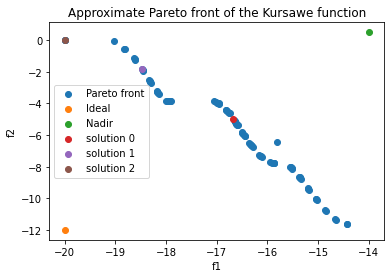

In [16]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

We decide to select the solution at index **1**, and to continue the iterations.

In [17]:
response = {"index": 1, "continue": True}
preferred_request.response = response

classification_request, plot_request = method.iterate(preferred_request)

Back at the classification phase of the NIMBUS method.

In [18]:
response = {
    "classifications": [">=", "<"],
    "number_of_solutions": 4,
    "levels": [-16, -1]
}
classification_request.response = response

save_request, plot_request = method.iterate(classification_request)

In [19]:
print(classification_request.content["message"])

Please classify each of the objective values in one of the following categories:
	1. values should improve '<'
	2. values should improve until some desired aspiration level is reached '<='
	3. values with an acceptable level '='
	4. values which may be impaired until some upper bound is reached '>='
	5. values which are free to change '0'
Provide the aspiration levels and upper bounds as a vector. For categories 1, 3, and 5,the value in the vector at the objective's position is ignored. Supply also the number of maximumsolutions to be generated.


Let us plot some of the solutions again:

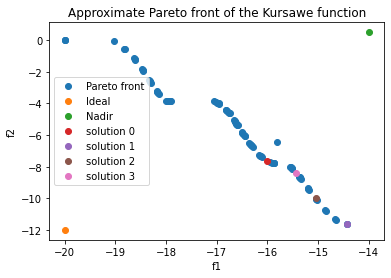

In [20]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

NIMBUS really took to heart our request to detoriate the first objective…

Suppose we like all of the solutions:

In [21]:
response = {"indices": [0, 1, 2, 3]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

Let us plot everything we have so far:

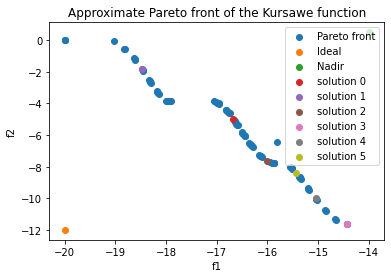

In [22]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(intermediate_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Assume we really like what we have between solutions 3 and 5. Let NIMBUS compute 3 intermediate solutions between them:

In [23]:
response = {
    "indices": [3, 4],
    "number_of_desired_solutions": 3,
    }
intermediate_request.response = response

save_request, plot_request = method.iterate(intermediate_request)

Plot the intermediate solutions:

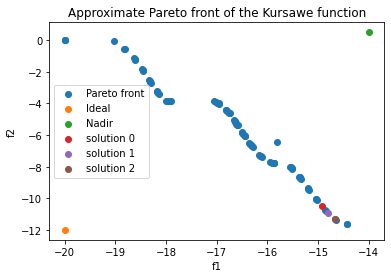

In [24]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(save_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

Let us save solution 1:

In [25]:
response = {"indices": [1]}
save_request.response = response

intermediate_request, plot_request = method.iterate(save_request)

We do not wish to generate any more intermediate solutions.

In [26]:
response = {"number_of_desired_solutions": 0, "indices": []}
intermediate_request.response = response

preferred_request, plot_request = method.iterate(intermediate_request)

Let us plot everything we have, and select a final solution:

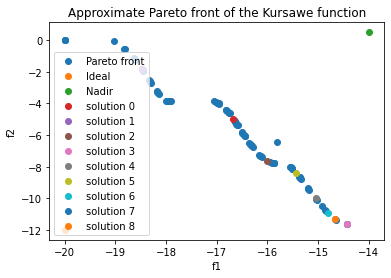

In [27]:
plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
for i, z in enumerate(preferred_request.content["objectives"]):
    plt.scatter(z[0], z[1], label=f"solution {i}")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

We REALLY like solution 6, so let us go with that:

In [28]:
response = {
    "index": 6,
    "continue": False,
    }

preferred_request.response = response

stop_request, plot_request = method.iterate(preferred_request)

We are done, let us bask in the glory of the solution found:

Final decision variables: [-1.02778293 -1.10011457 -1.09981982]


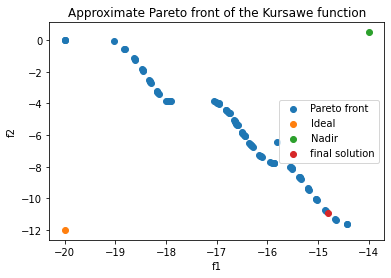

In [29]:
print(f"Final decision variables: {stop_request.content['solution']}")

plt.scatter(p_front[:, 0], p_front[:, 1], label="Pareto front")
plt.scatter(problem.ideal[0], problem.ideal[1], label="Ideal")
plt.scatter(problem.nadir[0], problem.nadir[1], label="Nadir")
plt.scatter(stop_request.content["objective"][0], stop_request.content["objective"][1], label=f"final solution")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Approximate Pareto front of the Kursawe function")
plt.legend()
plt.show()

# Lecture 14 (Part B), Decision making under uncertainty -> Follow slides in a pdf 